# Utility

In [159]:
import numpy as np
import pandas as pd
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import random
import torch
import torch.nn as nn

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, render_range):
        self.volume = deque(maxlen=render_range)
        self.net_worth = deque(maxlen=render_range)
        self.render_data = deque(maxlen=render_range)
        self.render_range = render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, date, open, high, low, close, volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.volume.append(volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        date = mpl_dates.date2num([pd.to_datetime(date)])[0]
        self.render_data.append([date, open, high, low, close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='red', colordown='blue', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        date_render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(date_render_range, self.volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(date_render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in date_render_range:
                if trade['Type'] == 'buy':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='blue', label='blue', s = 120, edgecolors='none', marker="v")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.yaxis.set_label_position('right')
        self.ax3.set_ylabel('Balance') # 여기 수정

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        # Necessary to view frames before they are unrendered
        plt.pause(0.001)

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.Transition = namedtuple('Transition',
                                ('state', 'action', 'next_state', 'reward'))

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Weight initialisation
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

#def OU_noise(action, mu=0, theta=0.15, sigma=0.3):
#    dx = -theta

#class OU_noise: # state에 노이즈를 입히는 것이 아니라 action에 노이즈를 입히는 것이다.
#    def __init__(self, state, mu=0, theta=0.15, sigma=0.3):
#        self.state = state
#        self.n_actions = 1
#        self.mu = mu
#        self.theta = theta
#        self.sigma = sigma
#        self.state = np.ones(self.n_actions) * self.mu
#        self.reset()
#
#    def reset(self):
#        self.state = np.ones(self.n_actions) * self.mu
#
#    def sample(self):
#        x = self.state
#        dx = self.beta * (self.alpha - x) + self.sigma * np.random.randn(len(x))
#        self.state = x + dx
#        return self.state

# Model

In [173]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.n_actions = 1

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 64)
        self.layer4 = nn.Linear(64, self.n_actions, bias=False) # continuos action space니까 1이 되어야 하지 않을까? # 
        # action size: 여기서는 비트코인 한 종류만 다루고 있으므로 마지막을 1로 처리
    
    def forward(self, state):
        x = state
        x = self.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x)) # 뒤에 tanh가 오는데 ReLU를 또 써?
        #x = self.layer3(x)

        return torch.tanh(self.layer4(x)) # tanh 함수는 결과값을 -1에서 1 사이로 가두어 준다. 그러므로 continuous action space에 알맞다.

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.n_actions = 1
        # Layer 1
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 512)
        self.batch_norm_1 = nn.BatchNorm1d(512)

        # Layer 2
        # In the second layer the actions will be inserted also 
        self.layer2 = nn.Linear(512, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256 + self.n_actions, 64)
        self.batch_norm_3 = nn.BatchNorm1d(64)

        # Output layer (single value)
        self.layer4 = nn.Linear(64, 1)


    def forward(self, state, action):
        x = state

        # Layer 1
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)

        # Layer 2
        x = self.layer2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)

        x = torch.cat((x, action), 1)  # Insert the actions
        x = self.layer3(x)
        x = self.batch_norm_3(x)
        x = F.relu(x)

        return self.layer4(x) # Value라서 x 대신 V라고도 부른다.

# Environment

In [231]:
import numpy as np
import random
from collections import deque, namedtuple
import copy
import torch
import torch.nn as nn
import torch.optim as optim
#from tensorboardX import SummaryWriter
import gymnasium as gym

from utils_ddpg import TradingGraph, ReplayMemory, init_weights #, OU_noise
from model import Actor, Critic

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

class TradingEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, render_range = 100):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.render_range = render_range # render range in visualization

        self.BATCH_SIZE = 64
        self.GAMMA = 0.99
        self.TAU = 0.1
        self.LR = 1e-4
        self.actor_loss = 0
        self.critic_loss = 0
        self.actor_losses = []
        self.critic_losses = []
        self.C = 24 * 30 # 한달마다 거래전략 수정

        #self.OU = OU_noise(1)

    
        self.memory = ReplayMemory(1000)

        # Action space from -1 to 1. -1
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,)) 

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, 10)

        self.Actor_target = Actor().to(device)
        self.Actor_target.apply(init_weights)
        self.Actor_behaviour = copy.deepcopy(self.Actor_target).to(device)
        self.Critic_target = Critic().to(device)
        self.Critic_target.apply(init_weights)
        self.Critic_behaviour = copy.deepcopy(self.Critic_target).to(device)


        self.actor_optimizer = optim.Adam(self.Actor_behaviour.parameters(), lr=self.LR)
        self.critic_optimizer = optim.Adam(self.Critic_behaviour.parameters(), lr=self.LR)

    # Create tensorboard writer
#    def create_writer(self):
#        self.replay_count = 0
#        self.writer = SummaryWriter(comment="Crypto_trader")

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(render_range=self.render_range) # init visualization
        self.trades = deque(maxlen=self.render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0

        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'volume']
                                        ])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume']
                                    ])
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)

        return obs

    # Execute one time step within the environment
    def step(self, action):
        #action = action.cpu()
        if action == int(action):
            pass
        else:
            action = action.item()

        #action = action.cpu() # 새로 추가한 부분
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'open'],
            self.df.loc[self.current_step, 'close'])
        date = self.df.loc[self.current_step, 'date_open'] # for visualization
        high = self.df.loc[self.current_step, 'high'] # for visualization
        low = self.df.loc[self.current_step, 'low'] # for visualization
        
        if action == 0: # Hold
            pass
        
        elif action > 0 and self.balance > 0:#self.initial_balance/100: # 0이 아닌 이유: 가끔 오류가 날 때 있음
            self.crypto_bought = self.balance * action / current_price # 현금 * action으로 정해진 비율만큼 이용해서 구매
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date' : date, 'High' : high, 'Low' : low, 'Total': self.crypto_bought, 'Type': "buy"})
        
        elif action < 0 and self.crypto_held * abs(action) > 0: 
            self.crypto_sold = self.crypto_held * abs(action) 
            self.balance += self.crypto_sold * abs(action) * current_price
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date' : date, 'High' : high, 'Low' : low, 'Total': self.crypto_sold, 'Type': "sell"})

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])

        # Calculate reward
        reward = self.net_worth - self.prev_net_worth

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        #obs = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        return obs, reward, done

    # render environment
    def render(self, visualize=False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            date = self.df.loc[self.current_step, 'date_open']
            open = self.df.loc[self.current_step, 'open']
            close = self.df.loc[self.current_step, 'close']
            high = self.df.loc[self.current_step, 'high']
            low = self.df.loc[self.current_step, 'low']
            volume = self.df.loc[self.current_step, 'volume']

            # Render the environment to the screen
            self.visualization.render(date, open, high, low, close, volume, self.net_worth, self.trades)
    
    def act(self, state, testmode): # select_action에 대응
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action = self.Actor_behaviour(state) 

        #action = action.cpu()
        #action = action.item()
        action_with_noise = action + torch.rand(1).to(device=device) * 0.1

        if action_with_noise > 1:
            action_with_noise = 1
        elif action_with_noise < -1:
            action_with_noise = -1
        
        if testmode == False:
            #return torch.tensor([[action_with_noise]], device=device, dtype=torch.long)
            return action_with_noise
        else:
            #return torch.tensor([[action]], device=device, dtype=torch.long)
            return action


        #if sample > eps_threshold:
        #    with torch.no_grad():
        #        return self.Actor(state).max(1).indices.view(1,1)
        #else:
        #    return torch.tensor([[np.random.choice(self.action_space)]], device=device, dtype=torch.long)
    

    def save(self, name="ddpg"):
        torch.save(self.Actor_target.state_dict(), f'./ddpg/{name}_Actor.h5')
        torch.save(self.Critic_target.state_dict(), f'./ddpg/{name}_Critic.h5')

    def load(self, name="ddpg"):
        self.Actor_target.load_state_dict(torch.load(f'./ddpg/{name}_Actor.h5', weights_only=True))
        self.Critic_target.load_state_dict(torch.load(f'./ddpg/{name}_Critic.h5', weights_only=True))
        
    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE * 5:
            return
        Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        #action_batch = action_batch.squeeze(1)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        #state_action_values = self.Actor(state_batch).gather(1, action_batch)
        #state_action_values = self.Actor(state_batch).gather(1, action_batch) 
        state_action_values = self.Critic_target(state_batch, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        #with torch.no_grad():
        #    #next_state_values[non_final_mask] = self.Actor(non_final_next_states, state_action_values).max(1).values
        #    next_state_values = self.Critic_behaviour(non_final_next_states, self.Actor_behaviour(non_final_next_states))#.max(1).values
        #    next_state_values = next_state_values.squeeze(1)
        
        next_state_values = next_state_values.unsqueeze(1)
        next_state_values[non_final_mask] = self.Critic_behaviour(non_final_next_states, self.Actor_behaviour(non_final_next_states))#.max(1).values
        next_state_values = next_state_values.squeeze()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
        expected_state_action_values = expected_state_action_values.unsqueeze(1)


        self.Critic_behaviour.train()
        critic_criterion = nn.HuberLoss()
        
        self.critic_optimizer.zero_grad()
        self.critic_loss = critic_criterion(state_action_values, expected_state_action_values)
        #torch.nn.utils.clip_grad_value_(self.Critic_behaviour.parameters(), 100)
        self.critic_loss.backward()
        self.critic_optimizer.step()

        self.Actor_behaviour.train()
        self.actor_optimizer.zero_grad()
        self.actor_loss = -torch.mean(self.Critic_behaviour(state_batch, self.Actor_behaviour(state_batch)))
        #torch.nn.utils.clip_grad_value_(self.Actor_behaviour.parameters(), 100)
        self.actor_loss.backward()
        self.actor_optimizer.step()

        if self.current_step % self.C == 0:
            self.soft_update_target(self.Critic_target, self.Critic_behaviour)
            self.soft_update_target(self.Actor_target, self.Actor_behaviour)

    def soft_update_target(self, target, original):
        for target_parameters, original_parameters in zip(target.parameters(), original.parameters()):
            target_parameters.data.copy_((1 - self.TAU) * target_parameters.data + self.TAU * original_parameters.data)

In [323]:

def train_agent(env, visualize=False, train_episodes=1, training_batch_size=500):
    #env.create_writer() # create TensorBoard writer
    #total_average = deque(maxlen=100) # save recent 100 episodes net worth
    #best_average = 0 # used to track best average net worth
    
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        for t in range(training_batch_size):
            env.render(visualize)
            action = env.act(state, testmode=False)
            next_state, reward, done = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
            #action = torch.tensor(action, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
            if done:
                break
            #action_onehot = np.zeros(3)
            #action_onehot[action] = 1
            env.memory.push(state, action, next_state, reward) # Store the transition in memory
            #next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            state = next_state
            env.optimize_model() # perform one step of the optimization on the policy network

            print(f"Episode {episode} net_worth: {env.net_worth}, step: {env.current_step}")
            print(f"Episode {episode} Actor loss: {env.actor_loss} Critic loss: {env.critic_loss}")
        if episode == train_episodes - 1:
            env.save()


In [22]:
def test_agent(env, visualize=False, test_episodes=1):
    env.load() # load the model
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = env.act(state, testmode=True)
            state, reward, done = env.step(action)
            print(f"Episode {episode} net_worth: {env.net_worth}")
            if env.current_step == env.end_step:
                break

In [307]:
with torch.no_grad():
    jk = train_env.Actor_behaviour(state)

In [309]:
jk.shape

torch.Size([1, 1])

In [116]:
np.random.rand(1)*0.1

array([0.05337198])

In [312]:
test1 = torch.tensor(5).unsqueeze(0).unsqueeze(0)
test2 = torch.tensor(3).unsqueeze(0).unsqueeze(0)

In [316]:
test1.shape

torch.Size([1, 1])

In [313]:
test1

tensor([[5]])

In [314]:
test2

tensor([[3]])

In [315]:
test1 + test2

tensor([[8]])

In [303]:
torch.sum(test1, test2, dtype = torch.float32)

TypeError: sum() received an invalid combination of arguments - got (Tensor, Tensor, dtype=torch.dtype), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
      didn't match because some of the arguments have invalid types: (Tensor, !Tensor!, dtype=torch.dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [326]:
test_df = df[train_size:]

In [327]:
test_df.shape

(11151, 6)

In [328]:
train_df.shape

(26016, 6)

In [333]:
torch.normal(mean=0, std=1, size=(1,))

tensor([-1.4634])

/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_77536/3396839587.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode 0 net_worth: 1000.0, step: 969
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 992.3905224792661, step: 970
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 996.1121183226408, step: 971
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 997.5434901059837, step: 972
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 984.1576590450336, step: 973
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 964.6383336409896, step: 974
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 943.1030697376854, step: 975
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 966.0015173766221, step: 976
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 965.6585980962172, step: 977
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 977.4561408403273, step: 978
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 987.2420367950224, step: 979
Episode 0 Actor loss: 0 Critic loss: 0
Episode 0 net_worth: 993.1117921

TypeError: expected Tensor as element 0 in argument 0, but got int

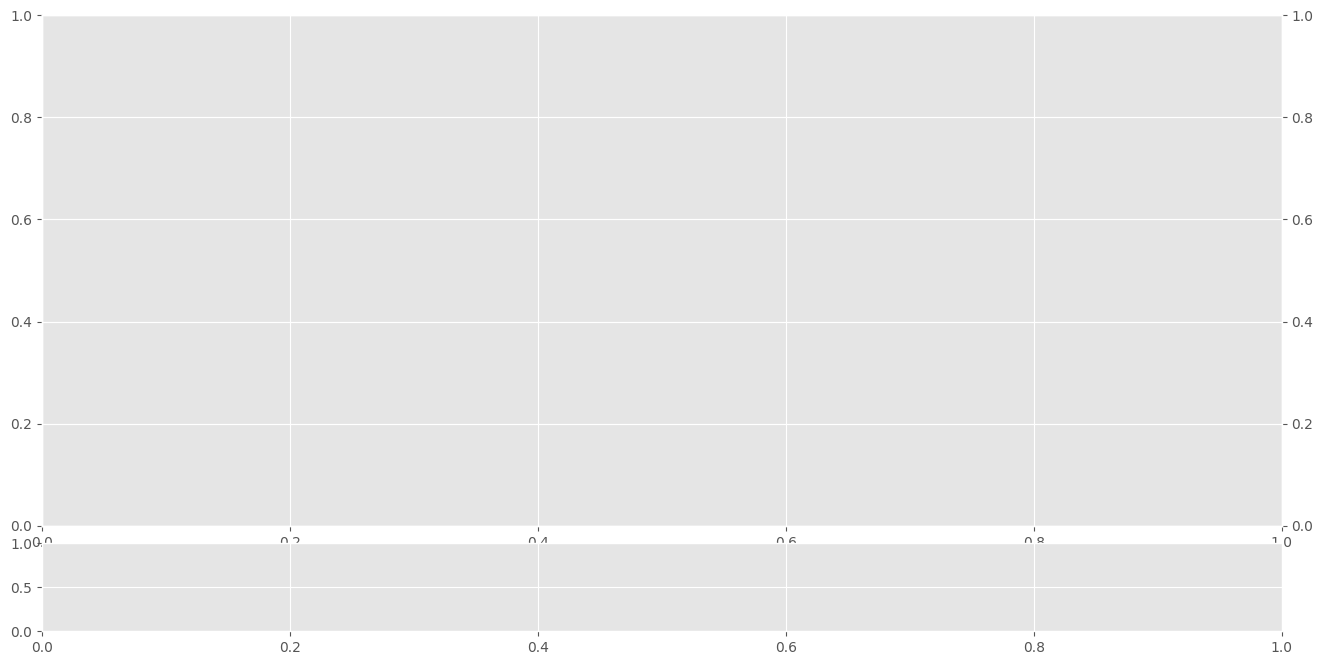

In [325]:
lookback_window_size = 50
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]

train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

train_agent(train_env, train_episodes=2, training_batch_size=500)

In [265]:
qwer = torch.tensor(5)
qwer.shape

torch.Size([])

In [266]:
int(qwer)

5

In [264]:
qwer = torch.tensor(qwer, dtype=torch.float32, device=device).unsqueeze(0)
qwer.shape

/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_77536/1927626417.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qwer = torch.tensor(qwer, dtype=torch.float32, device=device).unsqueeze(0)


torch.Size([1, 1])

/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_77536/3396839587.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


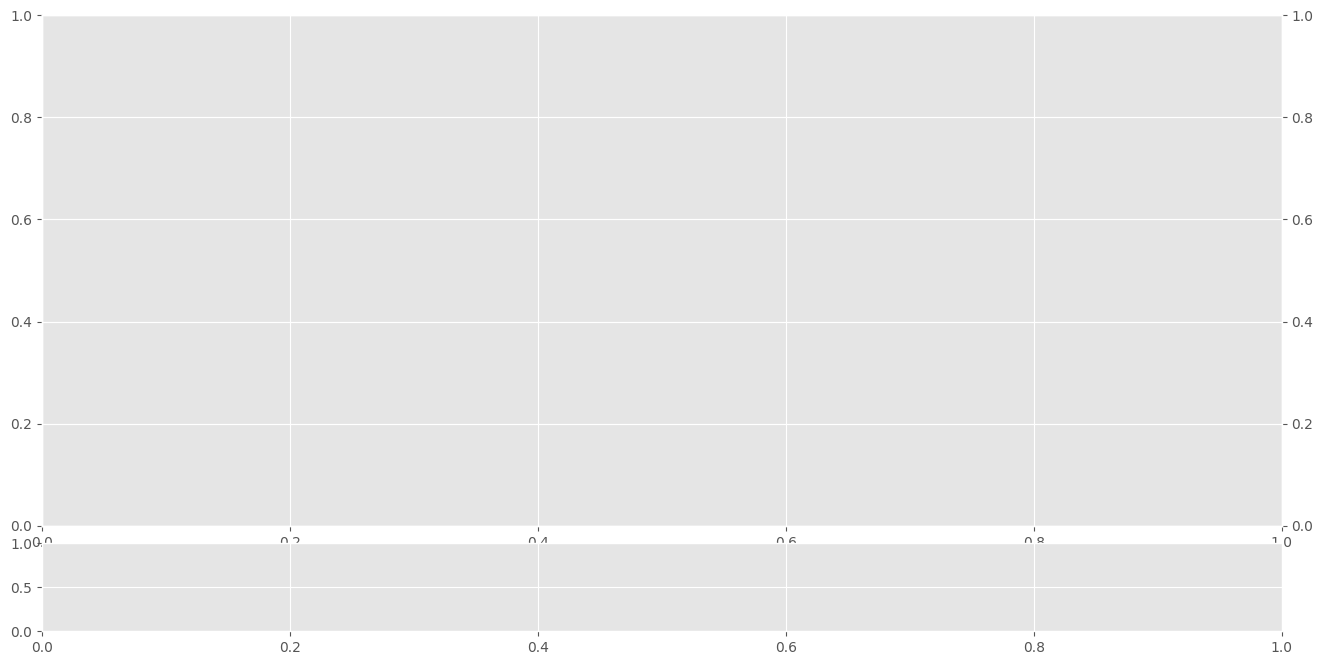

In [270]:
# 우선 100번 timestep만큼 돌려보자

lookback_window_size = 50
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]

lookback_window_size = 50

train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

memory = ReplayMemory(1000)

state = train_env.reset(env_steps_size = 500)
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

for _ in range(100):
    action = train_env.act(state, testmode=False)
    next_state, reward, done = train_env.step(action)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
    action = torch.tensor(action, dtype=torch.float32, device=device).unsqueeze(0)
    memory.push(state, action, next_state, reward)
    state = next_state
    #train_env.optimize_model()


In [271]:
Transition = namedtuple('Transition',
                ('state', 'action', 'next_state', 'reward'))
transitions = memory.sample(5)
batch = Transition(*zip(*transitions))

In [277]:
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                    batch.next_state)), device=device, dtype=torch.bool)
#non_final_mask = non_final_mask.unsqueeze(1)
non_final_next_states = torch.cat([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

In [278]:
action_batch

tensor([1., 1., 1., 1., 1.], device='mps:0')

In [279]:
action_batch = action_batch.unsqueeze(1)

In [280]:
action_batch.shape

torch.Size([5, 1])

In [281]:
action_batch

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')

In [282]:
state_action_values = train_env.Critic_target(state_batch, action_batch)

In [283]:
state_action_values

tensor([[14564.3311],
        [14176.2676],
        [14924.9541],
        [13175.2119],
        [14643.8428]], device='mps:0', grad_fn=<LinearBackward0>)

In [284]:
next_state_values = torch.zeros(5, device=device)
next_state_values = next_state_values.unsqueeze(1)
next_state_values[non_final_mask] = train_env.Critic_behaviour(non_final_next_states, train_env.Actor_behaviour(non_final_next_states))

In [285]:
next_state_values

tensor([[16393.7109],
        [15115.3018],
        [14176.2676],
        [13442.6133],
        [14419.3613]], device='mps:0', grad_fn=<AsStridedBackward0>)

In [286]:
next_state_values.shape

torch.Size([5, 1])

In [287]:
next_state_values = next_state_values.squeeze()
next_state_values.shape

torch.Size([5])

In [288]:
expected_state_action_values = (next_state_values * 0.99) + reward_batch

In [289]:
expected_state_action_values

tensor([16229.9170, 14966.0068, 14035.6611, 13308.0127, 14275.9980],
       device='mps:0', grad_fn=<AddBackward0>)

In [290]:
expected_state_action_values = expected_state_action_values.unsqueeze(1)
expected_state_action_values.shape

torch.Size([5, 1])

In [291]:
action_batch

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')

In [292]:

train_env.Critic_behaviour.train()
critic_criterion = nn.HuberLoss()
critic_optimizer = optim.Adam(train_env.Critic_behaviour.parameters(), lr=0.0001)
train_env.Critic_behaviour.zero_grad()
critic_loss = critic_criterion(state_action_values, expected_state_action_values)
critic_loss.backward()
torch.nn.utils.clip_grad_value_(train_env.Actor_behaviour.parameters(), 100)
critic_optimizer.step()


train_env.Actor_behaviour.train()
actor_optimizer = optim.Adam(train_env.Actor_behaviour.parameters(), lr=0.0001)
train_env.Actor_behaviour.zero_grad()
actor_loss = -torch.mean(train_env.Critic_behaviour(state_batch, train_env.Actor_behaviour(state_batch)))
actor_loss.backward()
torch.nn.utils.clip_grad_value_(train_env.Critic_behaviour.parameters(), 100)
actor_optimizer.step()

In [293]:
actor_loss

tensor(-10171.0459, device='mps:0', grad_fn=<NegBackward0>)

In [294]:
critic_loss

tensor(768.5527, device='mps:0', grad_fn=<HuberLossBackward0>)

In [295]:
train_env.net_worth

1039.8612413446551

In [296]:
action

tensor([1.], device='mps:0')